# Project T Final: Collaborative Filtering

*CS 189/289A, Fall 2020*

*Maxwell Chen and Abinav Routhu*

<!-- insert hand-drawn picture here -->

---

This notebook serves to introduce and explore the topic of Collaborative Filtering through mathematical formulation, along with application to the Netflix dataset.

Collaborative Filtering is a process or algorithm to filter information or patterns through the collaboration of multiple users, agents, or data sources.

We shall approach this through three paradigms:
1.   K-Nearest-Neighbors (KNN)
2.   Cosine Similarity
3.   SVD

In [1]:
# Load Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

To begin, we will load the MovieLens Dataset. MovieLens was a research project launched by GroupLens Research at the University of Minnesota, and was one of the earliest modern projects that investigated personalized recommendations via recommender systems. We will be using their Dataset for a similar purpose: recommending a user which movie to watch based on their own interests or preferences.

<hr>

# Question 1: Loading the Dataset

<hr>

**1.1:** Import `zipfile` and `from urllib.request import urlretrieve`. Use these libraries to load the MovieLens Dataset stored at http://files.grouplens.org/datasets/movielens/ml-100k.zip -- this is the "small" Dataset containing 100,000 ratings. If you are up for it, you can also load the expanded MovieLens Dataset stored at http://files.grouplens.org/datasets/movielens/ml-latest.zip -- this contains 27,000,000 ratings. For the purposes of this assignment, loading either Dataset will work.

Reference Material:

* [DataCamp Tutorial on zipfile module](https://www.datacamp.com/community/tutorials/zip-file)

* [GeeksForGeeks Tutorial on zipfile module](https://www.geeksforgeeks.org/working-zip-files-python/)

* [urllib.request Documentation](https://docs.python.org/3/library/urllib.request.html)

In [278]:
from urllib.request import urlretrieve
import zipfile

urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()

<hr>

**1.2:** We now have a raw .csv file containing our Dataset. As with many other problems involving machine learning or data mining, we must manipulate our raw data to a form that we can use.

First, investigate the structure of the zipped dataset we just downloaded. Open up each of the unzipped files on DataHub or your local machine, and describe the contents of each file:

<div style="color: blue">
    
**Answer:**
* `links` contains IDs to identify each movie. Each movie is associated with its ID on IMDB (Internet Movie DataBase) or TMDB (The Movie DataBase).
* `movies` contains IDs to identify each movie. Each entry has a 'title' field containing the name of the movie as well as the year it was released, and a 'genres' field consisting of the different genres the movie falls under, separated by vertical bar characters (the | character).
* `ratings` contains ratings from users on different movies. Each row corresponds to a user with a userID, who rates a movie with a movieID, on a scale from 1 to 5. The timestamp of the rating is also given.
* `tags` contains comments from users on the movies they reviewed/rated. Each row corresponds to a user with userID, a movie with movieID, and a short string containing a 'tag' for that movie. There may be multiple rows for the same user and the same movie, implying there are multiple tags that user assigned to that movie.

</div>

<hr>

**1.3:** Use your knowledge of data cleaning and processing from the first week of 16ML to load the different .csv files into multiple Pandas DataFrames. Use the provided columns stored in `user_features`, `ratings_features`, and `movie_features`. Use appropriate naming conventions for these DataFrames, such as "movies", for example. Then combine the Dataframes into a single DataFrame, using `user_id` as a primary key.

*Hint #1: When using `pd.read_csv`, you MUST use the flag `encoding='latin-1'` to properly read from the files.*

*Hint #2: Use `sep="|"` when reading in the csv file*

In [281]:
# Users
user_features = ["user_id", "age", "sex", "occupation", "zip_code"]
users = pd.read_csv("ml-100k/u.user", sep="|", names=user_features, encoding='latin-1')

# Ratings
ratings_features = ["user_id", "movie_id", "rating", "unix_timestamp"]
ratings = pd.read_csv("ml-100k/u.data", sep="\t", names=ratings_features, encoding='latin-1')

# Movies
movie_features = ['movie_id', 'title', 'release_date', "video_release_date", "imdb_url", "genre_unknown", "Action",
                  "Adventure", "Animation", "Children", "Comedy", "Crime", "Documentary", "Drama", "Fantasy",
                  "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
movies = pd.read_csv('ml-100k/u.item', sep='|', names=movie_features, encoding='latin-1')

all_data = ratings.merge(movies, on='movie_id').merge(users, on='user_id')
all_data.head()

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,genre_unknown,Action,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,age,sex,occupation,zip_code
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,0,0,0,49,M,writer,55105
1,196,257,2,881251577,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,...,0,0,1,0,0,0,49,M,writer,55105
2,196,111,4,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Truth%20About...,0,0,...,0,1,0,0,0,0,49,M,writer,55105
3,196,25,4,881251955,"Birdcage, The (1996)",08-Mar-1996,NaN,"http://us.imdb.com/M/title-exact?Birdcage,%20T...",0,0,...,0,0,0,0,0,0,49,M,writer,55105
4,196,382,4,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Adventures%20...,0,0,...,0,0,0,0,0,0,49,M,writer,55105


<hr>

# Question 2: Understanding and Visualizing the Dataset

<hr>

**2.1:** Distribution of Movie Genres
    
Utilize the knowledge of Pandas and NumPy you picked up in Week 1 to make an appropriate plot of the distribution of movies across different genres.

*Hint: Try a bar plot*

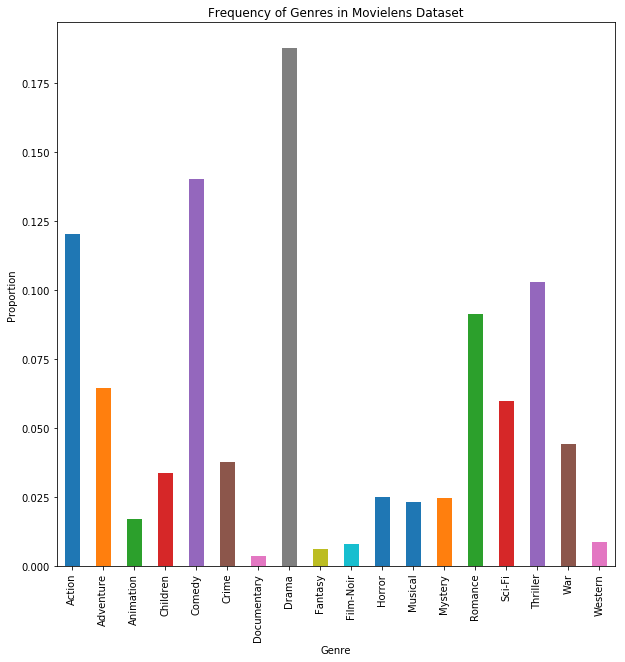

In [51]:
movie_columns = all_data.columns[9:27]

movie_genres = all_data[movie_columns]
genre_count = movie_genres.sum()
genre_count_sum = sum(genre_count)
genre_count /= genre_count_sum

plt.figure(figsize=(10, 10));
plt.title("Frequency of Genres in Movielens Dataset");
plt.xlabel("Genre");
plt.ylabel("Proportion");
genre_count.plot.bar();

<hr>

**2.2:** It is important to identify biases in our dataset that can skew our results or impact how generalizable our recommendation system is to novel users and novel movies. What might be some issues we run into by using this dataset?

<div style="color: blue">

**Answer:** From the plot, we see that the different genres are not equally represented: We have a high proportion of Drama, Comedy, Action, Thriller, and Romance films, while in contrast, we have very low representation for Documentary, Fantasy, Film-Noir, and Western Movies. This could present a problem if we want to make recommendations for users who like the less-represented films, as that means there is less data to work with.

</div>

<hr>

**2.2:** Distribution of User Ratings

As a sanity check, pick three different genres and plot the distribution of user ratings for each -- that is, plot the number of each rating from 1 to 5 received by movies belonging to each of the three genres. For example, plot the user rating for all Children movies, all Fantasy movies, and all Film-Noir movies. Note any similarities or differences, and whether these were expected.

*[Hint: Try multiple histograms or bar plots]*

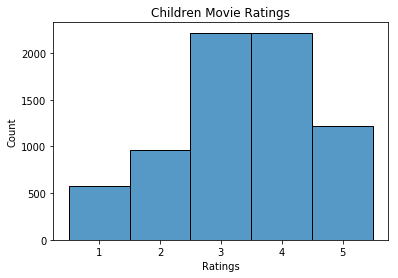

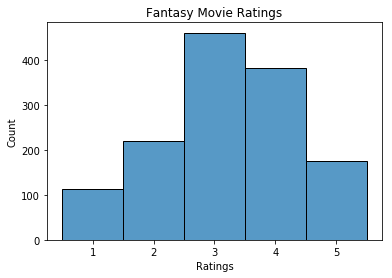

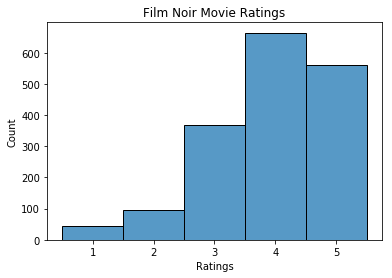

In [172]:
children_ratings = all_data[all_data["Children"] == 1]['rating'].astype('str').sort_values()
fantasy_ratings = all_data[all_data["Fantasy"] == 1]['rating'].astype('str').sort_values()
film_noir_ratings = all_data[all_data["Film-Noir"] == 1]['rating'].astype('str').sort_values()

sns.histplot(data=children_ratings, label="Children")
plt.title("Children Movie Ratings")
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.show()

sns.histplot(data=fantasy_ratings, label="Fantasy")
plt.title("Fantasy Movie Ratings")
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.show()

sns.histplot(data=film_noir_ratings, label="Film Noir")
plt.title("Film Noir Movie Ratings")
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.show()

<div style="color: blue">

**Answer:** All three distributions follow a roughly normal distribution with a center or average between 3 and 4. All genres seem to have slight left skew, which reflects that most users rated movies more positively than negatively.

</div>

The first approach we will investigate is the "Cluster-Based" Approach. We first define the following matrix known as the "user-item interaction matrix", where each row represents a user's ratings and each column represent's the ratings for a movie. In other words, $A_{ij}$ represents user $i$'s rating of movie $j$.

<hr>

# Question 3: Memory-Based Approaches and Clustering

<hr>

**3.1:** How many unique users and unique movies are there in our dataset? Assign your answers to `num_users` and `num_movies`, respectively.

*Hint: What data structure from CS 61B could be helpful here?*

In [52]:
# Answer to Hint: Use a set to implicitly remove duplicate entries and return just the unique users and movies
unique_users = set(all_data["user_id"])
unique_movies = set(all_data["movie_id"])

num_users = len(unique_users)
num_movies = len(unique_movies)

print("Number of ratings:", len(all_data))
print("Number of unique users:", num_users)
print("Number of unique movies:", num_movies)

Number of ratings: 100000
Number of unique users: 943
Number of unique movies: 1682


<hr>

**3.2:** How do these values differ from the dimensions of our raw data matrix? What does that tell us about the nature of our data?

<div style="color: blue">

**Answer:** We have far fewer unique users and unique movies than the number of ratings in the total dataset. This tells us two things: one, that each user rates many different movies, and two, our matrix is actually very "sparse," which we define as a matrix or vector where many of the values are 0.

</div>

<hr>

**3.3:** Construct the User-Item Interaction Matrix described above. Call it `interaction_matrix.` Print out its dimensions and the first few rows. Confirm that the dimensions match with the number of unique users and movies you found in **3.1**.

*Hint: Look into the Pandas function `df.pivot` (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html)*

In [65]:
truncated_data = ratings[["user_id", "movie_id", "rating"]]
interaction_matrix = truncated_data.pivot(index="user_id", columns="movie_id", values="rating").fillna(0);
print("Interaction Matrix Dimensions: ", interaction_matrix.shape);
display(interaction_matrix.head());

Interaction Matrix Dimensions:  (943, 1682)


movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<hr>
The simplest way to make a recommendation using this matrix is by grouping together users who are most similar to one another. In this way, we create groups, or clusters, that represent users who give similar ratings. This boils down to the algorithm known as K-Nearest Neighbors (KNN), which is used to classify data into K clusters of greatest similarity. This is spiritually similar to the K-Means Clustering you saw in lecture earlier this week -- K-Means Clustering is an unsupervised learning technique that assigns the data into $K$ clusters, while KNN looks at the $K$ data points most similar to a certain training point in order to assign it a class or label.

For the purposes of this assignment, we will look at a pre-imlemented [KNN Algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors) from [scikit-learn](https://scikit-learn.org/), the machine learning library we have been working with over the last few weeks of 16ML. The KNN Algorithm we use here is a bit simpler than what KNN truely should be, because instead of assigning labels based on the $K$ nearest neighbors, we will use this to simply identify the $K$ nearest neighbors.

[Note: Later on in EECS 16B, you will revisit K-Means Clustering. This will be used in lab to classify voice commands to control your car.]

<hr>

**3.4:** Read the linked documentation to understand how to use the KNN Algorithm from Scikit-Learn. What are the relevant functions and return values we can use?

<div style="color: blue">

Answer: We can import this Algorithm with the following line of code: `from sklearn.neighbors import NearestNeighbors`. The Algorithm is treated as a class with various methods. Next, we instantiate the Algorithm class with `nn = NearestNeighbors(n_neighbors=x)`. We can then use the `fit(X)` function to run the KNN algorithm on our `interaction_matrix`. 

Another useful function is `kneighbors`, which will return a `distance` matrix representing the distance from each vector to every other vector, and an `indcies` matrix containing the $k$ nearest neighbors i.e. vectors for each given vector.

</div>

**3.5:** Run KNN on `interaction_matrix` from the earlier part of this question. For now, use k = 10.

In [218]:
from sklearn.neighbors import NearestNeighbors
model = NearestNeighbors(n_neighbors=10)
model.fit(interaction_matrix)

distances, indices = model.kneighbors(interaction_matrix)
indices += 1
print("Shape of distances matrix:", distances.shape)
display(distances)
print("Shape of indices matrix:", indices.shape)
display(indices)

Shape of distances matrix: (943, 10)


array([[ 0.        , 55.06359959, 55.23585792, ..., 57.51521538,
        57.61076288, 57.62811814],
       [ 0.        , 25.63201124, 28.01785145, ..., 28.37252192,
        28.54820485, 28.65309756],
       [ 0.        , 20.95232684, 21.3541565 , ..., 22.09072203,
        22.20360331, 22.22611077],
       ...,
       [ 0.        , 20.71231518, 20.76053949, ..., 21.26029163,
        21.33072901, 21.3541565 ],
       [ 0.        , 37.16180835, 37.52332608, ..., 38.28837944,
        38.37968212, 38.39270764],
       [ 0.        , 43.35896678, 43.8634244 , ..., 45.22167622,
        45.2437841 , 45.40925016]])

Shape of indices matrix: (943, 10)


array([[  1, 738, 521, ..., 773, 215, 774],
       [  2, 701, 266, ..., 520, 651, 111],
       [  3, 317, 656, ..., 685,  61, 809],
       ...,
       [941, 742, 441, ...,  17, 578, 609],
       [942, 163, 856, ..., 205, 202, 656],
       [943, 933, 774, ..., 778, 175, 538]], dtype=int64)

<hr>

**3.5:** Let's look at the first user in our `interaction_matrix`. What other users is our user most similar to? What are the IDs of the movies these users liked?

In [237]:
first_user = indices[0]
display(first_user)

similar_users = (interaction_matrix.loc[first_user])
display(similar_users)

array([  1, 738, 521, 933, 715,  44, 868, 773, 215, 774], dtype=int64)

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
738,5.0,3.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
521,2.0,3.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
933,3.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
715,5.0,3.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,4.0,0.0,0.0,0.0,4.0,0.0,5.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
868,4.0,2.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
773,3.0,3.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<hr>

# Question 4: Cosine Similarity

One accessible way to perform collaborative filtering is through a method known as "cosine similarity". It boils down to the following:

* Treat each user row or movie column as a vector
* Determine the cosine of the angle between every pair of vectors

This can be expressed with the following expression: For vectors $i$ and $j$ of length $n$, their similarity is calculated as:
$$cos(\theta) = \frac{v_i v_j}{|v_i||v_j|} = \sum_{k=1}^{n}\frac{v_{i,k} v_{j,k}}{\sqrt{\sum_{k=1}^{n}v_{i,k}^2} \sqrt{\sum_{k=1}^{n}v_{j,k}^2}}$$

**4.1:** Compute a matrix representing the cosine similarity between users, i.e. treating each row of `interaction_matrix` as a vector. Assign this to `user_similarity`.

[Note: You may want to consider adding a small "fudge" factor such as 1e-10 to prevent any issues with ratings of 0.]

In [195]:
user_num = interaction_matrix.dot(interaction_matrix.T) + 1e-10
user_root_norm = np.array([np.sqrt(np.diagonal(user_num))])

user_similarity = num / (user_root_norm * user_root_norm.T)
user_similarity.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.166931,0.047460,0.064358,0.378475,0.430239,0.440367,0.319072,0.078138,0.376544,...,0.369527,0.119482,0.274876,0.189705,0.197326,0.118095,0.314072,0.148617,0.179508,0.398175
2,0.166931,1.000000,0.110591,0.178121,0.072979,0.245843,0.107328,0.103344,0.161048,0.159862,...,0.156986,0.307942,0.358789,0.424046,0.319889,0.228583,0.226790,0.161485,0.172268,0.105798
3,0.047460,0.110591,1.000000,0.344151,0.021245,0.072415,0.066137,0.083060,0.061040,0.065151,...,0.031875,0.042753,0.163829,0.069038,0.124245,0.026271,0.161890,0.101243,0.133416,0.026556
4,0.064358,0.178121,0.344151,1.000000,0.031804,0.068044,0.091230,0.188060,0.101284,0.060859,...,0.052107,0.036784,0.133115,0.193471,0.146058,0.030138,0.196858,0.152041,0.170086,0.058752
5,0.378475,0.072979,0.021245,0.031804,1.000000,0.237286,0.373600,0.248930,0.056847,0.201427,...,0.338794,0.080580,0.094924,0.079779,0.148607,0.071459,0.239955,0.139595,0.152497,0.313941


**4.2:** What does each value in the matrix represent? If there is a certain value along the diagonal, why is that the case? How could we now use this matrix to recommend movies to a user? What drawbacks are there with using this approach?

<div style="color: blue">

Answer: Each value in the matrix represents the "similarity" between two users as measured by the cosine similarity of their ratings represented as high-dimensional, sparse vectors. We see 1's along the diagonal, which makes sense, since that diagonal computes the similarity of each user with themselves.

We can recommend movies for a particular user in `user_similarity` by looking at the next highest values in each user's row. The highest values represent the most similar users, meaning the movies they rated highly are likely movies this particular user would also rate highly.

one drawback is that this only works for the users in our database. In other words, this `user_similarity` matrix must be recomputed each time a user rates a new movie or each time a new user uses our service. This algorithmic complexity can by shortened by only computing a new vector for the new user and recomputing the vector for the movies they've rated, but this is not as clean of a process as with the clustering approach we saw earlier.

</div>

**4.3:** Now compute a matrix representing the cosine similarity between movies, i.e. treating each column of `interaction_matrix` as a vector. Assign this to `item_similarity`.

[Note: You may want to consider adding a small "fudge" factor such as 1e-10 to prevent any issues with ratings of 0.]

In [196]:
item_num = interaction_matrix.T.dot(interaction_matrix) + 1e-10
item_root_norm = np.array([np.sqrt(np.diagonal(item_num))])

item_similarity = sim / (item_root_norm * item_root_norm.T)
item_similarity.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
movie_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.402382,0.330245,0.454938,0.286714,0.116344,0.620979,0.481114,0.496288,0.273935,...,3.538730e-02,2.948942e-13,3.931922e-13,5.897883e-13,3.538730e-02,1.179577e-12,3.931922e-13,5.897883e-13,4.718307e-02,0.047183
2,0.402382,1.000000,0.273069,0.502571,0.318836,0.083563,0.383403,0.337002,0.255252,0.171082,...,8.699929e-13,6.524947e-13,8.699929e-13,1.304989e-12,8.699929e-13,2.609979e-12,8.699929e-13,1.304989e-12,7.829936e-02,0.078299
3,0.330245,0.273069,1.000000,0.324866,0.212957,0.106722,0.372921,0.200794,0.273669,0.158104,...,1.076389e-12,8.072921e-13,1.076389e-12,1.614584e-12,3.229168e-02,3.229168e-12,1.076389e-12,1.614584e-12,1.076389e-12,0.096875
4,0.454938,0.502571,0.324866,1.000000,0.334239,0.090308,0.489283,0.490236,0.419044,0.252561,...,6.268145e-13,4.701109e-13,9.402218e-02,9.402218e-02,3.760887e-02,1.880444e-12,6.268145e-13,9.402218e-13,5.641331e-02,0.075218
5,0.286714,0.318836,0.212957,0.334239,1.000000,0.037299,0.334769,0.259161,0.272448,0.055453,...,1.046790e-12,7.850929e-13,1.046790e-12,1.570186e-12,1.046790e-12,3.140371e-12,1.046790e-12,1.570186e-12,1.046790e-12,0.094211


**4.4:** What does each value in the matrix represent? If there is a certain value along the diagonal, why is that the case? How could we now use this matrix to recommend movies to a user? What drawbacks are there with using this approach?

<div style="color: blue">

Answer: Each value in the matrix represents the "similarity" between two movies as measured by the cosine similarity of their ratings represented as high-dimensional, sparse vectors. We see 1's along the diagonal, which makes sense, since that diagonal computes the similarity of each movies with itself.

We can recommend new users that would like a particular movie in `item_similarity` by looking at the next highest values in each movie's column. The highest values represent the users who are most likely to also like the movie, meaning that the movie should be recommended to them.

One drawback is that this only works for the existing movies in our database. In other words, this `item_similarity` matrix must be recomputed each time a user rates a brand-new movie or each time a new movie is logged in our database. This algorithmic complexity can by shortened by only computing a new vector for the new movie and recomputing the vector for the users that have rated that movie, but this is not as clean of a process as with the clustering approach we saw earlier.

</div>

<hr>

# Question 5: Model-Based Approach: Matrix Factorization and Embeddings

There are a few issues with the cluster-based approach in Question 3. The biggest issue is that this casts the data in terms of the users we have data for. In other words, we are taking a 'User-User Approach' that is highly reliant on similar data or ratings between users in order to form reliable or accurate clusters. In reality, our interaction matrix is very sparse, meaning that many of the entries or values in it are 0. This means that it may be hard to identify similarity between users, and any slight changes will alter our recommendations.

Another approach we can use is known as an 'item-item approach' that instead leverages matrix factorization to break apart matrices into other matrices or vectors that have special meanings or interpretations.

<hr>

**5.1:** What are the two Matrix Factorizations you have seen in EECS 16A and EECS 16B? What are the tradeoffs or different use cases for one factorization over the other?

<div style="color: blue">

**Answer:** We have seen Diagonalization aka Eigenvalue Decomposition in EECS 16A, and have heard of the SVD from earlier weeks of 16ML / references in EECS 16B. Both factorization methods break a matrix apart into three matrices: either $P\Lambda P^T$ for Diagonalization, or $U\Sigma V^T$ the SVD. We should use the SVD because it generalizes Diagonalization to the non-square matrix we are working with. Further, SVD has a natural connection to dimensionality reduction and clustering, making it a great tool for factoring our matrix and understanding its components.

</div>

<hr>

Here is a quick refresher on the SVD:

For a matrix $A \in \mathbb{R}^{mxn}$, the "Full SVD" is the following matrix product:
$$A = U\Sigma V^T$$
where
$$U \in \mathbb{R}^{}$$
$$\Sigma \in \mathbb{R}^{}$$
$$V^T \in \mathbb{R}^{}$$

Alternatively, there is a "Compact SVD" that involves truncating these matrices to remove zero-value singular vectors corresponding to the Nullspace of $A$:

$$A = U_c\Sigma_c V_c^T$$
where
$$U_c \in \mathbb{R}^{}$$
$$\Sigma_c \in \mathbb{R}^{}$$
$$V_c^T \in \mathbb{R}^{}$$

As popularized during the 2006 Netflix Prize, there is a famed "SVD" Matrix Factorization Algorithm used for creating a recommendation system. NOTE: THIS IS A DIFFERENT SVD! Even though they are both called "SVD", and are spiritually related in the sense that they are both related to matrix decomposition/factorization, they are in fact, different algorithms/procedures entirely. They are related in the sense that after the following procedure, the resulting matrix $A$ should converge to the SVD.

<hr>

Our goal will be to factorize `interaction_matrix` and approximate it as the product $A = UV^T$. For a matrix $A \in \mathbb{R}^{m x n}$, it will be equal to the product $U \in \mathbb{R}^{m x d}$ and $V^T \in \mathbb{R}^{d x n}$.

In the literature, U is referred to as the User Embeddings, while V is referred to as the Movie Embeddings. Each row of U, represented by $U_i$, denotes the "essence" of user $i$, while each row of $V$ i.e. each column of $V^T$, represented by $V_j$, denotes the "essence" of movie $j$.

**5.2:** How can we approximate the matrix A using a sum instead of a matrix product?

<div style="color: blue">

Answer: We already have `interaction_matrix`, where the rows represent each user's ratings for the movies in the dataset, while each column represents all of the ratings a single movie received. So, we can iterate over these vectors to calculate the following:

$$A^*_{i,j} = \vec{u_i}^T\vec{v_j}$$

</div>

**5.3:** Why can't we simply ues the row and column vectors in `interaction_matrix` to compute this?

<div style="color: blue">

Answer: $u_i$ and $v_j$ are embeddings that represent the abstract meaning or value of each user or movie. This is spiritually similar to how the singular vectors in the SVD are different from the rows and columns in the original matrix $A$.

</div>

**5.4:** Calculate $A^*$, the approximation for $A$, using gradient descent with randomly-initialized embedded vectors for $U$ and $V$.

In [259]:
U = np.random.normal(size=[interaction_matrix.shape[0], 5])
V = np.random.normal(size=[interaction_matrix.shape[1], 5])

In [260]:
gamma = 0.1

# for u in range(len(U)):
#     for v in range(len(V)):
for u in range(50):
    for v in range(50):
        for _ in range(100):
            pred = np.dot(U[u], V[v])
            actual = interaction_matrix.iloc[u, v]
            error = pred - actual
            U[u] = U[u] + gamma * error
            V[v] = V[v] + gamma * error

In [271]:
A_star = np.dot(U, V.T)

<hr>

# Question 6: Extensions

Through this assignment, we hvae explored the mathematical underpinnings for two methods of collaborative filtering that are used to build recommendation systems. If you wish to further investigate this application of Machine Learning, here are some external packages that are used in production settings, as well as links to recent developments:

**Surprise**

Surprise is a Package for SciPy. It is a dedicated SciPy package for building and analyzing Recommender Systems. In particular, it has native access to various datasets such as MovieLens, and also has a wide array of prediction algorithms.

* [SurpriseLib Website](http://surpriselib.com/)
* [GitHub Link](https://github.com/NicolasHug/Surprise)

**Deep Learning and Deep Neural Networks**

Later on in 16ML, we will introduce the idea of Deep Learning, which relies heavily on using Neural Networks with many, many layers to perform complex computations. These are considered state-of-the-art models that are at the forefront of recent advances in many different fields of Machine Learning, and are a valid option for developing a recommendation system.

**Regularization**

When performing Model-Based Collaborative Filtering, we can run into the issue of underregularization. This is a concept that was discussed earlier in 16ML during Week 4. In essence, regularization allows us to "smooth" out our data by "lifting" up small, near-zero values in our data that can cause numerical instability and/or unexpected magnification of small values. Regularization can help with Collaborative Filtering by dealing with movies that were not rated by many users, or users who did not rate many movies. In this way, it can help reduce error in predicting or recommending new movies to users, or conversely, identifying new users who might like a given movie.

<hr>

# References

* Baptiste Rocca. Introduction to recommender systems. https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada,2019.
* Simon Funk. Netflix update:Try this at home. https://sifter.org/simon/journal/20061211.html, 2006.
* Yehuda Koren. The bellkor solution to the netflix grand prize. Published on Netflix PrizeForums, 2009.
* Build a Recommendation Engine With Collaborative Filtering. https://realpython.com/build-recommendation-engine-collaborative-filtering/
* Prince Grover. Various Implementations of Collaborative Filtering https://towardsdatascience.com/various-implementations-of-collaborative-filtering-100385c6dfe0
* Intro to Recommender Systems: Collaborative Filtering https://www.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/
* Alesha Tony. All You Need to Know About Collaborative Filtering https://www.digitalvidya.com/blog/collaborative-filtering/
* MovieLens Dataset https://grouplens.org/datasets/movielens/